# Introduction : objectives

The purpose of this notebook is to process data from a flux tower at Col du Lautaret, to calculate and plot footprints for specific periods with the Kljun et al. (2015) model and to enable the use of these footprint values for further work and comparisons. To achieve this last goal, the focus is on interoperability with suitable formats and easy reuse with fonctions.

# Importation of packages and modules

This notebook was developed with:  
- Python 3.13.2  
- Jupyter Notebook  
- Libraries : pandas, numpy, matplotlib, contextily, rasterio, rioxarray, xarray  
- Modules : data_preparation, footprint_analysis
- See 'environment.yml' in the repository for more infos. 

In [1]:
import sys
sys.path.append('/home/jovyan//ICOS-M2-internship-alise/scripts/')

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import data_preparation as datprep
import footprint_analysis as FFP_analys
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import contextily as cx
from rasterio.transform import rowcol
import rasterio
import rasterio.plot
from rasterio.windows import from_bounds
import rioxarray
from rasterio.enums import Resampling
from rasterio.warp import reproject
import xarray as xr
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

import watermark
%load_ext watermark

In [3]:
%watermark --iversions

rioxarray : 0.19.0
xarray    : 2025.3.1
matplotlib: 3.10.1
pandas    : 2.2.3
sys       : 3.13.2 | packaged by conda-forge | (main, Feb 17 2025, 14:10:22) [GCC 13.3.0]
rasterio  : 1.4.3
watermark : 2.5.0
contextily: 1.6.2
numpy     : 2.2.4



# 1) Data importation

In [4]:
# Import low frequency data (meteorological variables) from 2019 to 2023
lofreq_all = datprep.read_csv_file('/mnt/data-summer-shared/ICOS_Data_AliseROBERT/FR-CLt_*_LoFreq.csv', na_values=[-9999.0])

In [5]:
# Import high frequency data (flux variables) from 2019 to 2023
flux_all = datprep.read_csv_file('/mnt/data-summer-shared/ICOS_Data_AliseROBERT/FR-CLt_*_flux.csv', na_values=[-9999.0])

# 2) Data preparation

## Selection and standardization of the variables

In [6]:
# Standardize the codes of the variable for 2022 and 2023
flux_all[3] = flux_all[3].rename(columns={'CO2_2_1_1': 'CO2_1_1_1'})
flux_all[4] = flux_all[4].rename(columns={'CO2_2_1_1': 'CO2_1_1_1'})
lofreq_all[3] = lofreq_all[3].rename(columns={'WD_1_1_1': 'WD_2_1_1'})
flux_all[3] = flux_all[3].rename(columns={'WS_2_1_1': 'WS_1_1_1'})

In [9]:
# Select only interesting columns in flux datasets
useful_columns = ['TIMESTAMP_START', 'WS_1_1_1', 'MO_LENGTH_1_1_1', 'V_SIGMA_1_1_1', 'USTAR_1_1_1']
flux_all = [flux[useful_columns] for flux in flux_all]

In [ ]:
# Format time data 
lofreq_all = datprep.prep_timestamp(lofreq_all)
flux_all = datprep.prep_timestamp(flux_all)

## Add wind direction and snow depth to flux dataframes

In [ ]:
# Add the corresponding columns of lofreq dataframes to flux dataframes
columns = ['D_SNOW_1_1_1', 'WD_2_1_1']
flux_all = datprep.add_lofreqcol(flux_all, lofreq_all, columns)

## Concatenate the list of flux dataframes into one single dataframe

In [8]:
flux_data_all = pd.concat(flux_all, ignore_index=True)
print(flux_data_all)

       TIMESTAMP_START  TIMESTAMP_END  CO2_1_1_1  CO2_MIXING_RATIO_1_1_1  \
0         201906010000   201906010030    402.408                 405.897   
1         201906010030   201906010100    402.206                 405.713   
2         201906010100   201906010130    401.143                 404.445   
3         201906010130   201906010200    400.891                 403.911   
4         201906010200   201906010230    400.932                 403.946   
...                ...            ...        ...                     ...   
87240     202412122130   202412122200        NaN                     NaN   
87241     202412122200   202412122230        NaN                     NaN   
87242     202412122230   202412122300        NaN                     NaN   
87243     202412122300   202412122330        NaN                     NaN   
87244     202412122330   202412130000        NaN                     NaN   

       FC_1_1_1  H2O_1_1_1  H2O_MIXING_RATIO_1_1_1    H_1_1_1  LE_1_1_1  \
0      2.544

## Cleaning : remove missing values

In [11]:
# Remove the NaN of the main variables (used later for footprint calculation)
columns = ["WD_2_1_1", "WS_1_1_1", "MO_LENGTH_1_1_1", "V_SIGMA_1_1_1", "USTAR_1_1_1"]
flux_data_all = flux_data_all.dropna(subset=columns)

## Add zm (measurement height) to the dataframe

In [12]:
# Import sensor height
zsensor = pd.read_csv("/mnt/data-summer-shared/ICOS_Data_AliseROBERT/zsensor.csv")

# Time formatting
zsensor['date'] = pd.to_datetime(zsensor['date'], format="%Y%m%d")

# Sort sensor heights by dates
zsensor = zsensor.sort_values('date')

In [13]:
print(zsensor)

    h_capteur       date
0        5.01 2015-07-07
1        2.85 2019-10-08
2        3.45 2019-12-03
3        4.10 2020-01-30
4        3.45 2020-03-16
5        2.85 2020-04-22
6        2.80 2020-10-12
7        4.06 2020-12-09
8        2.80 2021-03-31
9        3.97 2021-12-07
10       2.70 2022-05-19
11       4.00 2023-01-06
13       3.00 2023-05-05
12       2.95 2023-07-06


In [14]:
# Associate each date of the flux dataframe with a value of h_capteur
flux_data_all = pd.merge_asof(
    flux_data_all,
    zsensor.rename(columns={'date': 'TIMESTAMP_START'}),
    on='TIMESTAMP_START',
    direction='backward'  # Take the last sensor height known at this date
    )

In [15]:
# For each date, calculate zm : if there is snow, zm is the difference between the sensor height and the snow depth
# If no snow, zm = h_capteur
flux_data_all['zm'] = flux_data_all.apply(
        lambda row: row['h_capteur'] - row['D_SNOW_1_1_1'] 
        if row['D_SNOW_1_1_1'] > 0 else row['h_capteur'], 
        axis=1
    )

## Add an arbitrary value for the boundary layer height h

In [16]:
flux_data_all['H_RANDOM'] = 1000.

In [17]:
flux_data_all

,TIMESTAMP_START,CO2_1_1_1,WS_1_1_1,MO_LENGTH_1_1_1,V_SIGMA_1_1_1,USTAR_1_1_1,D_SNOW_1_1_1,WD_2_1_1,h_capteur,zm,H_RANDOM
0,2019-06-01 00:00:00,402.408,0.993511,11.24490,0.513305,0.146562,NaN,252.1,5.01,5.010,1000.0
1,2019-06-01 00:30:00,402.206,0.828337,-12.36150,0.401650,0.080132,NaN,198.2,5.01,5.010,1000.0
2,2019-06-01 01:00:00,401.143,0.737088,-91.58720,0.510083,0.084260,NaN,291.3,5.01,5.010,1000.0
3,2019-06-01 01:30:00,400.891,1.490440,18.69130,0.643529,0.178924,NaN,220.2,5.01,5.010,1000.0
4,2019-06-01 02:00:00,400.932,1.242340,28.58040,0.586084,0.165796,NaN,349.5,5.01,5.010,1000.0
...,...,...,...,...,...,...,...,...,...,...,...
67644,2023-12-31 21:30:00,312.482,6.426750,58.04190,1.315260,0.262981,0.508,238.2,2.95,2.442,1000.0
67645,2023-12-31 22:00:00,306.191,4.739200,3184.81000,0.968852,0.176605,0.499,264.4,2.95,2.451,1000.0
67646,2023-12-31 22:30:00,290.332,4.454990,66.03790,0.998072,0.152707,0.485,264.8,2.95,2.465,1000.0
67647,2023-12-31 23:00:00,300.548,5.184130,7.04546,1.455220,0.120351,0.487,260.8,2.95,2.463,1000.0


**Now, the dataframe is ready for footprint calculation, with the required variables. So the next step will be to determine different periods, with specific micro-meteorological and/or vegetative stages.**

# 3) Isolate certain periods

## 3) 1) Night-time VS day-time

In [18]:
# Partitioning between daytime and nighttime : add a column with "True" when it is night
flux_data_all['Night'] = flux_data_all['TIMESTAMP_START'].apply(datprep.is_night)

## 3) 2) Phenologic phases (based on NDVI)

### Import and prepare the data

In [19]:
# Import NDVI values from 2019 to 2023
NDVI_all = datprep.read_csv_file('/mnt/data-summer-shared/ICOS_Data_AliseROBERT/*_Lautaret_halfhour.csv', na_values=[-9999.0])

In [20]:
# Change the name of the first column of NDVI_2023 into TIMESTAMP (standardization)
NDVI_all[4].columns.values[0] = "TIMESTAMP"

In [21]:
# Select only interesting columns : time and NDVI values
useful_columns = ['TIMESTAMP','NDVI_skye_ref']
NDVI_all = [NDVI[useful_columns] for NDVI in NDVI_all]

In [22]:
# Concatenate all the dataframes
NDVI_data_all = pd.concat(NDVI_all, ignore_index=True)
df = NDVI_data_all

### Smooth the NDVI

In [23]:
# Change the TIMESTAMP format into DatetimeIndex
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.set_index('TIMESTAMP')

In [24]:
# Smooth the data with rooling median (20 values, centered) then rolling mean (30 values, centered) on daily median
df['NDVI_smoothed'] = df['NDVI_skye_ref'].resample('d').median().rolling(20, center = True).median().rolling(30,center=True).mean()

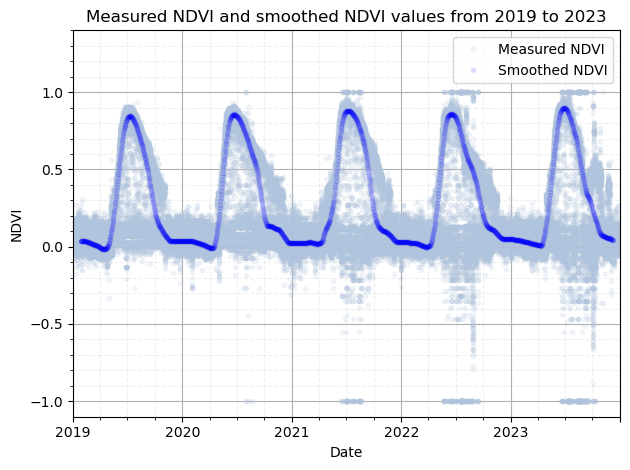

In [25]:
# Plot the measured NDVI values (light blue) and the smoothed NDVI (dark blue)
fig, ax = plt.subplots()

df['NDVI_skye_ref'].plot(ax=ax, style='.', alpha=0.15, color='lightsteelblue', label='Measured NDVI')
df['NDVI_smoothed'].plot(ax=ax, style='.', alpha=0.1, color='blue', label='Smoothed NDVI')

# Add a grid
grid_y_ticks = np.arange(-1.0, 1.5, 0.1)
ax.grid(which = 'both')
ax.set_yticks(grid_y_ticks , minor = True)
ax.grid(which = 'minor', alpha = 0.2, linestyle = '--')

ax.set_ylabel('NDVI')
ax.set_xlabel('Date')
ax.set_title("Measured NDVI and smoothed NDVI values from 2019 to 2023")
ax.legend()

plt.tight_layout()
plt.show()

This plot, representing the measured and smoothed NDVI as a function of time, shows that the NDVI follows a seasonal pattern linked to the vegetation stages and the snow cover. So the next step will be to isolate these phases.

### Detect the different phases of NDVI

In [26]:
# Remove the ligns where NDVI_smoothed is NaN
df = df.dropna(subset=['NDVI_smoothed'])

In [27]:
# Detect the different phases thanks to the derivative
df = datprep.detect_phase(df)

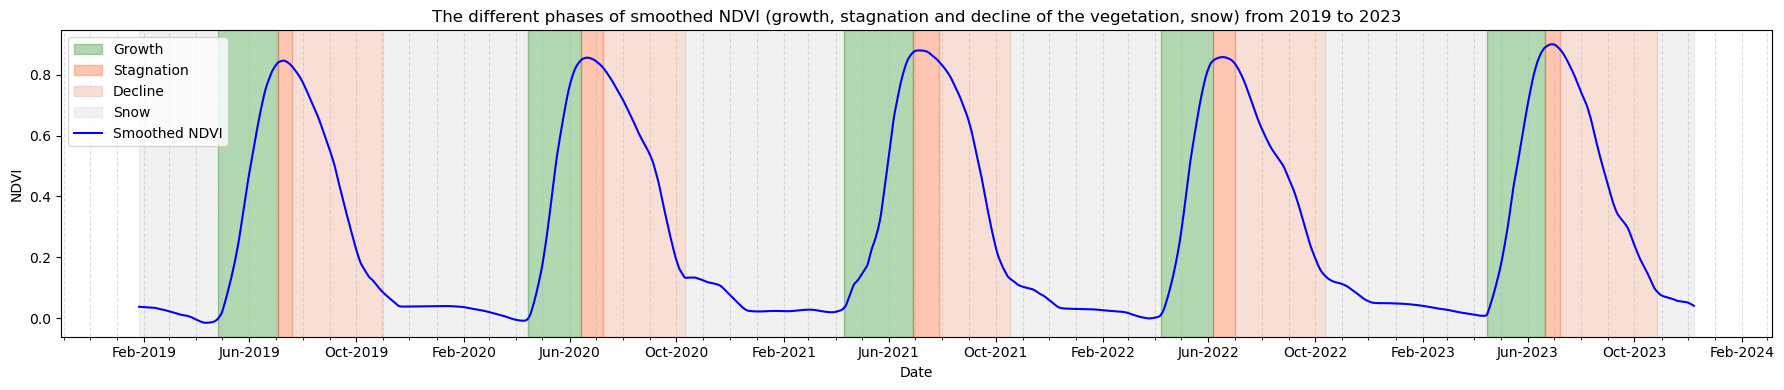

In [28]:
# Plot the smoothed NDVI with the different phases 
colors = {'Growth': 'green', 'Stagnation': 'orangered', 'Decline': 'darksalmon', 'Snow': 'lightgray'}
fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(df.index, df['NDVI_smoothed'], label='Smoothed NDVI', color='blue')

# Add colored bands
current = df['phase_label'].iloc[0]
start = df.index[0]

for i in range(1, len(df)):
    phase = df['phase_label'].iloc[i]
    if phase != current:
        ax.axvspan(start, df.index[i], color=colors.get(current, 'white'), alpha=0.3)
        start = df.index[i]
        current = phase

ax.axvspan(start, df.index[-1], color=colors.get(current, 'white'), alpha=0.3)

# Set the x axis scaling
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax.grid(True, axis='x', which='both', linestyle='--', alpha=0.4)

ax.set_title("The different phases of smoothed NDVI (growth, stagnation and decline of the vegetation, snow) from 2019 to 2023")
plt.ylabel('NDVI')
plt.xlabel('Date')

# Add color legend
patches = [mpatches.Patch(color=color, alpha=0.3, label=phase) for phase, color in colors.items()]
ax.legend(handles=patches + [plt.Line2D([], [], color='blue', label='Smoothed NDVI')], loc='upper left')

plt.tight_layout()
plt.show()

This plot represents the smoothed NDVI (blue line), with the different phases detected as a function of the derivative. It highlights the seasonal variability of NDVI and, by extension, that of vegetation and snow cover. The different durations and onsets of the phases for each year are more clearly distinguished. This information is relevant, because CO2 fluxes vary according to the phenological state of the grassland.

### Add the phases to the flux dataframe

In [29]:
# Add a "DATE" column in the flux dataframe
flux_data_all['DATE'] = pd.to_datetime(flux_data_all['TIMESTAMP_START']).dt.date

# Create a DataFrame with the name of the phase for each day
phases_NDVI = df[['phase_label']].copy()
phases_NDVI = phases_NDVI.reset_index()
phases_NDVI['DATE'] = phases_NDVI['TIMESTAMP'].dt.date
phases_NDVI = phases_NDVI[['DATE', 'phase_label']]

# Merge by date
flux_NDVI = pd.merge(
    flux_data_all,
    phases_NDVI,
    on='DATE',
    how='left'
)

# Remove 'DATE'
flux_NDVI.drop(columns='DATE', inplace=True)
 
print(flux_NDVI)

          TIMESTAMP_START  CO2_1_1_1  WS_1_1_1  MO_LENGTH_1_1_1  \
0     2019-06-01 00:00:00    402.408  0.993511         11.24490   
1     2019-06-01 00:30:00    402.206  0.828337        -12.36150   
2     2019-06-01 01:00:00    401.143  0.737088        -91.58720   
3     2019-06-01 01:30:00    400.891  1.490440         18.69130   
4     2019-06-01 02:00:00    400.932  1.242340         28.58040   
...                   ...        ...       ...              ...   
67644 2023-12-31 21:30:00    312.482  6.426750         58.04190   
67645 2023-12-31 22:00:00    306.191  4.739200       3184.81000   
67646 2023-12-31 22:30:00    290.332  4.454990         66.03790   
67647 2023-12-31 23:00:00    300.548  5.184130          7.04546   
67648 2023-12-31 23:30:00    308.901  6.097490         33.79060   

       V_SIGMA_1_1_1  USTAR_1_1_1  D_SNOW_1_1_1  WD_2_1_1  h_capteur     zm  \
0           0.513305     0.146562           NaN     252.1       5.01  5.010   
1           0.401650     0.080132    

**In this section, different periods are isolated. This processing is essential, because wind regime evolves from night to day and can have an impact on the flux origin. As for the vegetation phases, their categorization will facilitate the interpretation of CO2 sources. Vegetation is expected to sequester less during stagnaton and decline than during plant growth.**

# 4) Calculate footprints for the different phases, with contours from 10 to 90%

8 combinations are possible : Snow/Day, Snow/Night, Growth/Day, Growth/Night, Stagnation/Day, Stagnation/Night, Decline/Day, Decline/Night.

In [30]:
# Create a dictionary with the footprint climatology for each specific case
FFP_climato_all = {}

# List of the different phases and states :
phases = ['Snow', 'Growth', 'Stagnation', 'Decline']
daynight = [True, False]

for phase in phases:
    for night in daynight:
        # Name of the variable
        key = f"{phase}_{'night' if night else 'day'}"

        # Filter the data
        subset = flux_NDVI[(flux_NDVI['phase_label'] == phase) & (flux_NDVI['Night'] == night)]

        # Calculate the footprint climatology for each case
        FFP_climato = FFP_analys.run_FFP_90(subset)

        FFP_climato_all[key] = FFP_climato

**For each specific case, we can obtain a first overview of the footprint extent with a 10 meters resolution and contour lines representing 10 to 90% of a source area's contribution to the flux footprint. The next step will be to plot it with different backgrounds and additionnal info, that can help with interpretation.**

# 5) Plot the footprint climatologies

## 5) 1) On a map (html), with the associated windrose

In [34]:
# Set tower coordinates (longitude and latitude in WGS84, EPSG : 4326)
lon_tower = 6.410519
lat_tower = 45.041375

## Example for snow/day-time

In [35]:
# Extract contours coordinates (longitudes and latitudes)
coord_snow_day = FFP_analys.contour_coord_extract(FFP_climato_all['Snow_day'], lon_tower, lat_tower) 


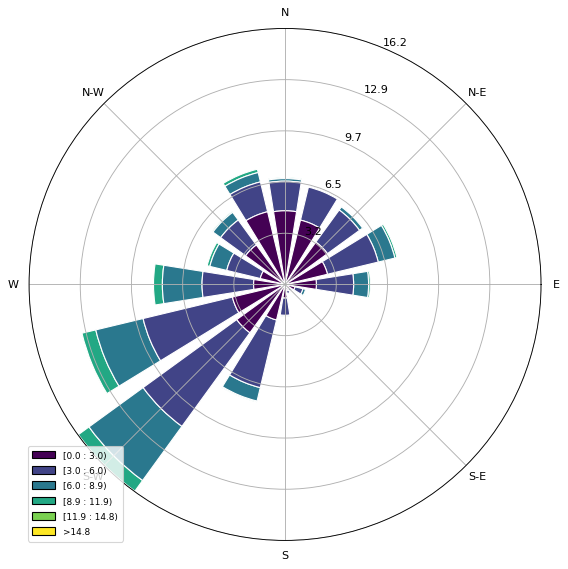

In [34]:
# Create an html map with Geoportail background and a windrose of the specific period
flux_data_snow_day = flux_NDVI[(flux_NDVI['phase_label'] == 'Snow') & (flux_NDVI['Night'] == False)]
map_footprint_snow_day = FFP_analys.map_footprint(flux_data_snow_day, lat_tower, lon_tower, coord_snow_day)
map_footprint_snow_day

In [35]:
# Save the map (optionnal)
#map_footprint_snow_day.save('map_footprint_snow_day.html')

**These functions provide a method to obtain an interactive (zoomable) map, with the associated windrose for comparison purposes. However, since it is more suited to digital display, we need an alternative way to plot the footprint climatology.**

## 5) 2) Overlay DSM (Digital Surface Model), IGN and footprint climatology

## Import MNT/DSM

In [31]:
# Open the elevation data
mnt_path = '/mnt/data-summer-shared/ICOS_Data_AliseROBERT/MNS2m_jardin.tif'

with rasterio.open(mnt_path) as src:
    mnt = src.read(1)
    mnt_extent = src.bounds
    mnt_crs = src.crs

## Convert station coordinates into the CRS of the raster

In [36]:
# Transformation of the coordinates
x0_mnt, y0_mnt = FFP_analys.transform_coordinates(lon_tower, lat_tower, crs_in="EPSG:4326", crs_out=mnt_crs)

## Crop the MNT to the domain size

In [37]:
# Define the limits to crop the MNT
domain_size = 400
bounds = (x0_mnt-domain_size, y0_mnt-domain_size, x0_mnt+domain_size, y0_mnt+domain_size)

In [38]:
# Crop the MNT with this limits
with rasterio.open(mnt_path) as src :
    window = from_bounds(*bounds, transform=src.transform)
    mnt_cropped = src.read(1, window=window)
    cropped_transform = src.window_transform(window)

## Calculate the relative altitudes to the tower (0 m at tower location)

In [39]:
# Calculate the tower altitude
row_cropped, col_cropped = rowcol(cropped_transform, x0_mnt, y0_mnt)
z0_cropped = mnt_cropped[row_cropped, col_cropped]

# Substract it to every value of the MNT
mnt_cropped_relative = mnt_cropped - z0_cropped

## Plot the 8 cases with MNT, roads and hydrography

In [40]:
# Set the titles for each case
titles = [
    'Snow - Night', 'Snow - Day',
    'Growth - Night', 'Growth - Day',
    'Stagnation - Night', 'Stagnation - Day',
    'Decline - Night', 'Decline - Day'
]

In [41]:
# Convert every contours into GeoDataFrame with the same CRS as the MNT
coord_all = []

for data in FFP_climato_all.values() :
    contours_coord = FFP_analys.contour_coord_extract(data,lon_tower, lat_tower)
    contours_gdf = FFP_analys.contours_to_gdf(contours_coord).to_crs(mnt_crs)
    coord_all.append(contours_gdf)

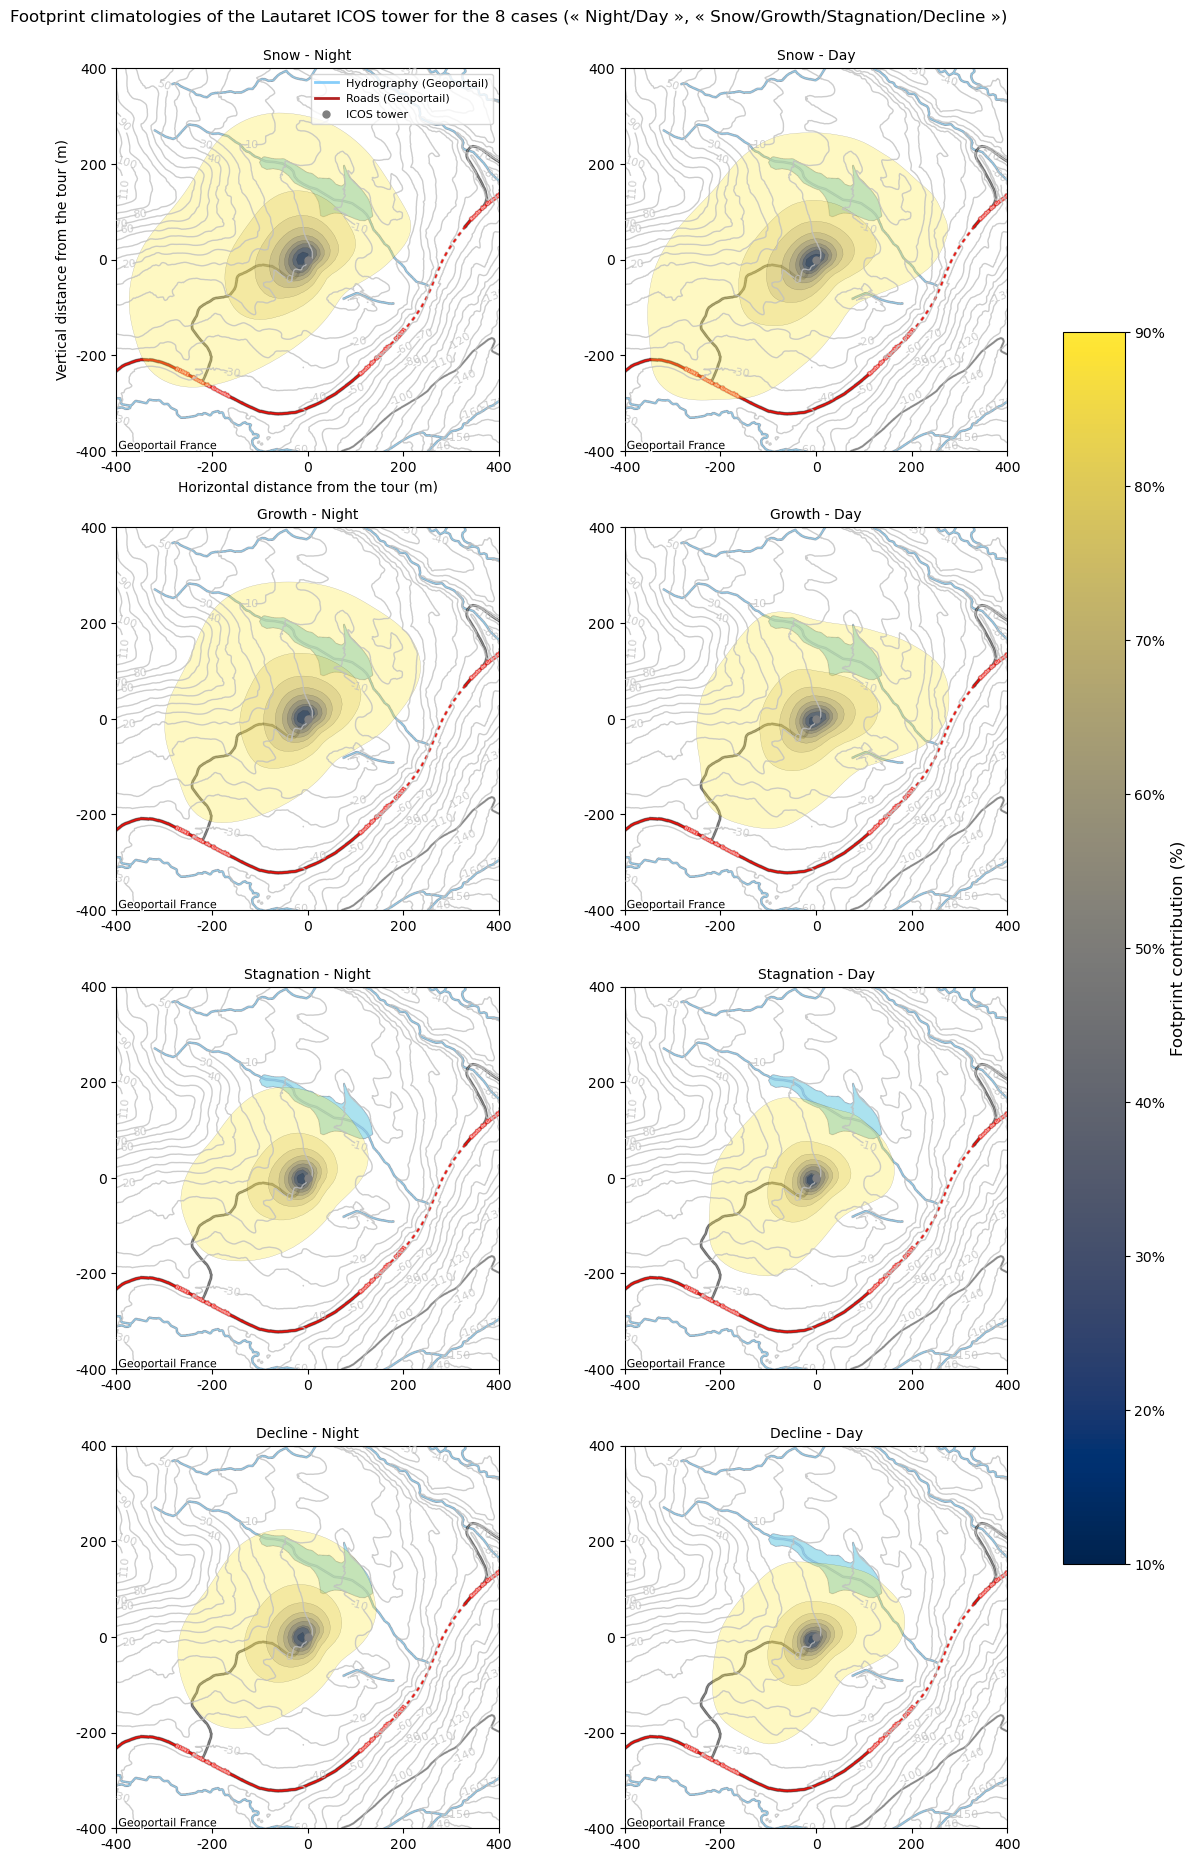

In [42]:
# Plot the 8 climatologies with additionnal info (hydrography, roads, elevation)
fig, axes = plt.subplots(4, 2, figsize=(20, 20))
axes = axes.flatten() 

fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=-0.5)

# Loop for each case
for i, (contours_gdf, ax) in enumerate(zip(coord_all, axes)):
    # Set y and x extent
    x_extent = np.array([x0_mnt - domain_size, x0_mnt + domain_size])
    y_extent = np.array([y0_mnt - domain_size, y0_mnt + domain_size])
    ax.set_xlim(x_extent)
    ax.set_ylim(y_extent)

    # Draw contour lines
    rows, cols = mnt_cropped_relative.shape
    x = np.linspace(x_extent[0], x_extent[1], cols)
    y = np.linspace(y_extent[1], y_extent[0], rows)
    X, Y = np.meshgrid(x, y)

    contour_lines = ax.contour(X, Y, mnt_cropped_relative, levels=30, colors="silver", linewidths=1, linestyles='solid', alpha=0.8)
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt="%.0f") # Add the elevation value on the contour line

    # Add the footprint's contours
    contours_sorted = contours_gdf.sort_values(by="label", ascending=False)
    norm_fp = mcolors.Normalize(vmin=contours_gdf["label"].min(), vmax=contours_gdf["label"].max())

    contours_sorted.plot(
        column="label",
        cmap='cividis',
        norm=norm_fp,
        ax=ax,
        edgecolor="black",
        linewidth=0.2,
        alpha=0.3,
    )

    # Add a dot for the ICOS tower
    ax.plot(x0_mnt, y0_mnt, marker="o", color="grey", markersize=5, label='ICOS tower')

    # Add Geoportail background for roads and hydrographic network
    cx.add_basemap(ax, crs=mnt_crs, source=cx.providers.GeoportailFrance.Hydrography_Hydrography, alpha=1)
    cx.add_basemap(ax, crs=mnt_crs, source=cx.providers.GeoportailFrance.Transportnetworks_Roads, alpha=1)

    ax.set_xticks(np.linspace(x_extent[0], x_extent[1], 5))
    ax.set_yticks(np.linspace(y_extent[0], y_extent[1], 5))
    ax.set_xticklabels([int(x - x0_mnt) for x in np.linspace(x_extent[0], x_extent[1], 5)])
    ax.set_yticklabels([int(y - y0_mnt) for y in np.linspace(y_extent[0], y_extent[1], 5)])

    ax.set_title(titles[i], fontsize=10)

    if i == 0 :
        ax.set_xlabel("Horizontal distance from the tour (m)")
        ax.set_ylabel("Vertical distance from the tour (m)")

        # Legend for Geoportail background
        legend_elements = [
            Line2D([0], [0], color='lightskyblue', lw=2, label='Hydrography (Geoportail)'),
            Line2D([0], [0], color='firebrick', lw=2, label='Roads (Geoportail)'),
            Line2D([0], [0], marker='o', color='grey', lw=0, label='ICOS tower', markersize=5)
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=8)

# Add a colorbar with the percentage of footprint contribution
sm = ScalarMappable(cmap='cividis', norm=norm_fp)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', shrink=0.7, pad=0.03)
cbar.set_label("Footprint contribution (%)", fontsize=12)
cbar.formatter = mticker.FuncFormatter(lambda x, pos: f"{x*100:.0f}%")
cbar.update_ticks()

plt.title("Footprint climatologies of the Lautaret ICOS tower for the 8 cases (« Night/Day », « Snow/Growth/Stagnation/Decline »)", loc= 'right',y=4.7)

#plt.savefig('all_footprints.png')
plt.show()

The footprint climatologies are represented by colored areas for each value of the contribution to the footprint (from 10 to 90%). The relief is illustrated by contour lines showing the relative altitude to the tower (m), located at the grey point in the middle of the map. In the background, the hydrological elements are shown in blue and the main road axis in red. **This plot shows that for all cases, the wetland is contained in whole or in part in the flux footprint. It contributes more to the measured flux during the "snow" and "vegetation growth" phases. The extent and shape of the footprint climatology is also variable between day and night, for a given period. Throughout the year, the beginning of the ridges in the Northwest is also captured by the tower. This more pronounced relief, as well as the main road for "Snow" conditions, can influence the emission and transport of CO2 in the atmosphere.**

# 6) Reproject the footprint onto another model grid

To facilitate the comparison with other models like Parflow, it is necessary to have the same grid and resolution. In this section, the main objective is to build a tool to reproject footprint values on a given model grid.

## Plot the model grid and the tower location on it

In [44]:
# Open the model grid
grid_path = '/mnt/data-summer-shared/ICOS_Data_AliseROBERT/Mask_10m_adj.tif'

with rasterio.open(grid_path) as src:
    grid = src.read(1)
    grid_transform = src.transform
    grid_crs = src.crs
    extent = rasterio.plot.plotting_extent(src)

In [45]:
# Convert the tower coordinates (longitude, latitude) into position on the Parflow grid
x0_conv, y0_conv = FFP_analys.transform_coordinates(lon_tower, lat_tower, crs_in="EPSG:4326", crs_out=grid_crs)

# Get the tower position in the mesh (indices)
col, row = ~grid_transform * (x0_conv, y0_conv)
print(f"Position of the tower on the grid : column={float(col)}, row={float(row)}")

Position of the tower on the grid : column=56.90509498261963, row=34.23143311718013


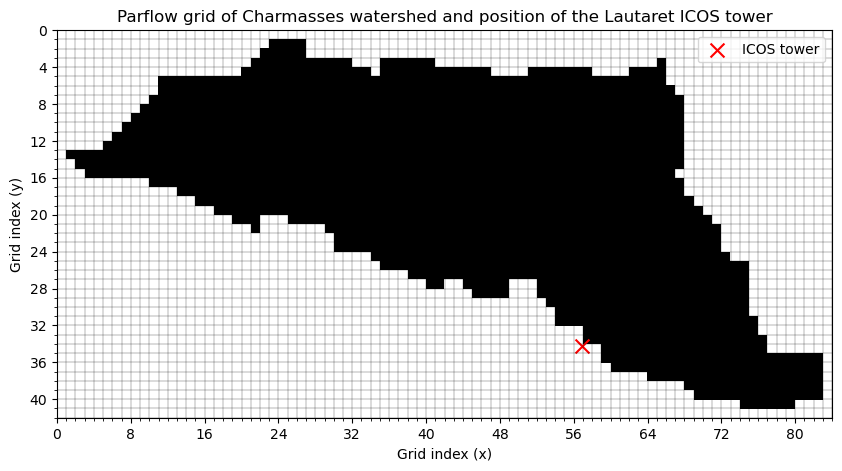

In [46]:
# Plot the model grid and the tower position
fig, ax = plt.subplots(figsize=(10, 10))

cax = ax.imshow(grid, cmap='gray', origin='upper', extent=extent)

# Grid
num_rows, num_cols = grid.shape
x_ticks = np.arange(0, num_cols + 1) * grid_transform.a + grid_transform.c
y_ticks = np.arange(0, num_rows + 1) * grid_transform.e + grid_transform.f

ax.set_xticks(x_ticks, minor=True)
ax.set_yticks(y_ticks, minor=True)
ax.grid(which='both', color='black', linestyle='-', linewidth=0.2)

# Add a cross for the tower position
ax.scatter(x0_conv, y0_conv, color='red', s=100, marker='x', label=f'ICOS tower')

ax.set_title("Parflow grid of Charmasses watershed and position of the Lautaret ICOS tower")
ax.set_xlabel('Grid index (x)')
ax.set_ylabel('Grid index (y)')
ax.legend()

# Index  on axis
col_indices = np.arange(0, num_cols + 1, max(1, num_cols // 10))
row_indices = np.arange(0, num_rows + 1, max(1, num_rows // 10))

ax.set_xticks(x_ticks[col_indices])
ax.set_xticklabels(col_indices)

ax.set_yticks(y_ticks[row_indices])
ax.set_yticklabels(row_indices)

plt.show()

This image illustrates the Parflow model grid with the indices of the mesh. Each black square represents an area where a value is provided by the model. The ICOS tower is located on the edge of the grid and not on a node, we need to artifically change the tower's location to facilitate reprojection.

### With that, calculate new coordinates for the tower position, on a nod of Parflow grid

In [47]:
x0_conv2 = x0_conv + 0.95 # To reach column = 57
y0_conv2 = y0_conv + 2.31 # To reach row = 34

## Example for stagnation/day

In [48]:
# Calculate the footprint climatology with 2.5 m resolution (multiple of 10, the resolution of Parflow grid)
clim_test_stagn_day = FFP_analys.run_FFP_nc(flux_NDVI[(flux_NDVI['phase_label'] == 'Stagnation') & (flux_NDVI['Night'] == False)])

## Formatting : footprint dictionary to tif

In [49]:
# Transform the x/y footprint grid to Lambert 93 coordinates (corrected regarding Parflow grid)
clim_test_stagn_day['x_2d'] = x0_conv2 + clim_test_stagn_day['x_2d']
clim_test_stagn_day['y_2d'] = y0_conv2 + clim_test_stagn_day['y_2d']

In [50]:
# Convert the footprint dictionary into a xarray Dataset
clim_stagn_day_ds = FFP_analys.FFPdict_to_nc(clim_test_stagn_day)

In [51]:
# Assign a spatial reference to footprint xarray (Lambert-93)
xr_footprint = clim_stagn_day_ds.footprint.rio.write_crs("EPSG:2154")
# Set dimension order (y,x is necessary for GeoTIFF)
xr_footprint = xr_footprint.transpose('y', 'x')
#Saving
xr_footprint.rio.to_raster("/mnt/data-summer-shared/ICOS_Data_AliseROBERT/footprint_test.tif")

In [52]:
# Check raster transform
print(xr_footprint.rio.transform())

| 2.50, 0.00, 967764.50|
| 0.00, 2.50, 6443113.95|
| 0.00, 0.00, 1.00|


## Resampling of footprint values from 2.5x2.5 to 10x10m grid (Parflow)

In [53]:
# Open footprint GeoTIFF
footprint_raster = rioxarray.open_rasterio('/mnt/data-summer-shared/ICOS_Data_AliseROBERT/footprint_test.tif')

In [54]:
# Open Parflow grid geoTIFF into xarray
model_grid = rioxarray.open_rasterio('/mnt/data-summer-shared/ICOS_Data_AliseROBERT/Mask_10m_adj.tif')

In [55]:
# Creating an empty array with Parflow grid dimensions
resampled = np.empty((model_grid.sizes['y'], model_grid.sizes['x']), dtype=footprint_raster.dtype)

In [56]:
# Reprojection of the fooprint values onto the Parflow grid, by addition
reproject(
    source=footprint_raster.values,
    destination=resampled,
    src_transform=footprint_raster.rio.transform(),
    src_crs=footprint_raster.rio.crs,
    dst_transform=model_grid.rio.transform(),
    dst_crs=model_grid.rio.crs,
    resampling=Resampling.sum
)

(array([[1.01110096e-08, 1.05936112e-08, 1.11182714e-08, ...,
         3.84689079e-07, 3.58302976e-07, 3.33474880e-07],
        [1.02927888e-08, 1.07608967e-08, 1.12719231e-08, ...,
         3.99255102e-07, 3.71042050e-07, 3.45098820e-07],
        [1.05310871e-08, 1.09850598e-08, 1.14809255e-08, ...,
         4.14300512e-07, 3.84609800e-07, 3.57955097e-07],
        ...,
        [1.16142448e-07, 1.24086254e-07, 1.32752098e-07, ...,
         2.16172163e-06, 1.90785029e-06, 1.69118612e-06],
        [1.28776562e-07, 1.37791757e-07, 1.47621141e-07, ...,
         2.21425636e-06, 1.95794374e-06, 1.73823067e-06],
        [1.42839390e-07, 1.52882157e-07, 1.63810547e-07, ...,
         2.24364127e-06, 1.98984797e-06, 1.77122274e-06]], shape=(42, 84)),
 Affine(10.0, 0.0, 967895.7469,
        0.0, -10.0, 6444155.203))

In [57]:
# Create a new xarray to store the reprojected values
footprint_resampled = xr.DataArray(
    resampled,
    coords={
        'y': model_grid.y,
        'x': model_grid.x
    },
    dims=['y', 'x'],
    name='footprint_resampled'
)

In [58]:
# Keep only the values on the cells covered by the Parflow model
footprint_masked = footprint_resampled.where(model_grid == 1)

## Plot the results

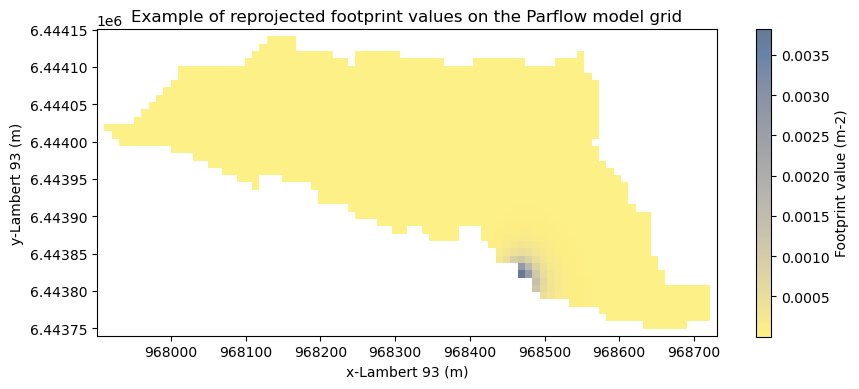

In [72]:
x = footprint_masked['x'].values
y = footprint_masked['y'].values

extent = [x.min(), x.max(), y.min(), y.max()]
          
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
im = ax.imshow(footprint_masked.values, origin='upper', extent=extent, cmap = 'cividis_r', alpha = 0.6) 
plt.title("Example of reprojected footprint values on the Parflow model grid")
plt.xlabel("x-Lambert 93 (m)")
plt.ylabel("y-Lambert 93 (m)")
plt.colorbar(im, ax=ax, label="Footprint value (m-2)")

plt.show()

This image illustrates the transition from 2.5x2.5m footprint values to a 10x10m model grid. **To compare Parflow values with the flux measured by the ICOS tower, this reprojection will be systematic. We can deduce from this work the relevant importance of the wetland in the reprojected footprint.**

# 7) Save in daily netCDF files for further work

**Warning : the following cell is particularly time-consuming, only run it if necessary**

In [165]:
# Calculate every single footprint climatology and save it in a netCDF file
# FFP_analys.data_to_daily_nc(flux_NDVI, '../private-storage/data-runs-daily/')

In [62]:
# Example for output netCDF file
xr_test = xr.open_dataset('/mnt/data-summer-shared/ICOS_Data_AliseROBERT/footprint_2019-06-01.nc')
xr_test

<xarray.Dataset> Size: 111MB
Dimensions:    (timestamp: 44, x: 561, y: 561)
Coordinates:
  * x          (x) float64 4kB -700.0 -697.5 -695.0 -692.5 ... 695.0 697.5 700.0
  * y          (y) float64 4kB -700.0 -697.5 -695.0 -692.5 ... 695.0 697.5 700.0
  * timestamp  (timestamp) datetime64[ns] 352B 2019-06-01 ... 2019-06-01T23:3...
Data variables:
    footprint  (timestamp, x, y) float64 111MB ...
    night      (timestamp) <U5 880B ...
    phase      (timestamp) <U6 1kB ...
Attributes: (12/15)
    Title:                        Single flux footprints ICOS Lautaret (2019-...
    Summary:                      Flux footprints integrated over 30 min from...
    Subjects:                     Flux footprint, grassland CO2 flux, ICOS
    Creation_Date:                2025-06-24
    Conventions:                  CF-1.8
    Model_Used:                   FFP, Kljun et al. (2015), doi:10.5194/gmd‐8...
    ...                           ...
    Aknowledgement:               This work is the result of a M2 internship ...
    Variables:                    X, Y, Timestamp, Night, Phase Label, Footpr...
    Coordinate_Reference_System:  
    Tower_Location_Latitude:      45.041375
    Tower_Location_Longitude:     6.410519
    Tower_Location_CRS:           WGS 84

# Conclusion

Accurate knowledge of the position and size of surface source areas and their contribution to the measured CO<sub>2</sub> flux is of crucial importance to interpret flux tower measurements. In this work, the footprint extent and its evolution over the seasons can be determined using the FFP model of Kljun et al. (2015). Cross-referenced with field information, this is of great interest for more specific future questions: What is the contribution of the wetland to the measured flux? Do CO<sub>2</sub> exchanges differ depending on wind orientation and source areas ? The output data from this notebook (netCDF files containing footprint values) will be used for model comparison.